# Trabalho Prático 2 - Aprendizado de Máquina

### Giovanna Louzi Bellonia - 2017086015

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# 1. Leitura e pré-processamento dos dados

Primeiro foi lido o dataset e guardado em uma variável df com uma atribuição para os nomes das colunas para ajudar no entendimento dos dados.

As colunas que não são as classes, representam uma posição em um "tabuleiro" de jogo da velha. Que pode estar preenchida por x (se o jogador X marcou aquela posição em algum momento do jogo), o (se o jogador O marcou aquela posição em algum momento do jogo) e b (se essa posição ainda não foi escolhida por nenhum dos jogadores).

As possíveis classes desses dados são duas: 'positive' e 'negative'. A primeira significa que o jogador X ganha a partida, e a segunda que não ganha.

In [2]:
columns = [
    "top_left_square", "top_middle_square", "top-right-square",
    "middle-left-square", "middle-middle-square", "middle-right-square",
    " bottom-left-square", "bottom-middle-square", "bottom-right-square",
    
    "class"
]

df = pd.read_table("tic-tac-toe.data", sep=",", names=columns)
df

,top_left_square,top_middle_square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


Text(0, 0.5, 'Quantidade')

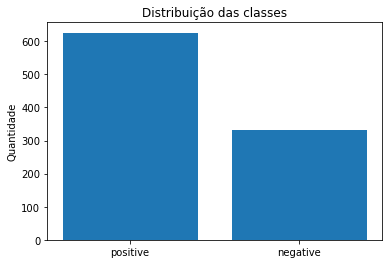

In [3]:
counter = df['class'].value_counts()
class_names = df['class'].value_counts().index.tolist()
plt.bar(class_names, counter)
plt.title('Distribuição das classes')
plt.ylabel('Quantidade')

# 2. AdaBoost

O AdaBoost é uma técnica de boosting. O boosting combina diferentes modelos (fracos) - que vão ser chamados de stumps - na expectativa de gerar um modelo final mais interessante, levando em conta as decisões que cada modelo vai ter para predizer um dado. A ideia é que com vários modelos fracos, ao fazer a votação da predição, encontraremos um resultado quase ótimo depois de várias iterações. A diferença do Adaboost para a formulação mais simples do boosting, é que cada h (ou stump) tem um alpha, que vai dizer quão importante cada h é para a decisão final.

O Adaboost vai associar um peso a cada exemplo, sendo esse pesso, inicialmente 1/n, em que n é a quantidade de exemplos. Nas próximas iterações, os pesos dos exemplos vão mudando de acordo com o erro do stump atual, mas a soma dos pesos continua dando 1. Se estou errando muito aquele ponto aumento o peso do ponto. 

Na nossa função do AdaBoost, iremos passar como parâmetros o X e y que serão utilizados para treinar os dados e a quantidade de iterações que iremos fazer, ou seja, a quantida de modelos/stumps que iremos gerar. O stump, por ter que ser um modelo fraco, será uma árvore de decisão de altura 1. A cada iteração do algoritmo, os stumps são guardados em um vetor, e, em outro vetor, os seus respectivos alphas. Ao fim, a função retorna esses dois vetores dos stumps e dos alphas.

A função predict vai receber um X para ser predito, além dos stumps e dos alphas que serão utilizados para fazer essa predição.

In [4]:
def compute_stump_error(y, y_pred, weights):
    is_diff = (y != y_pred).astype(int)
    
    return sum(weights * is_diff)

def compute_stump_alpha(error):
    
    return 0.5*np.log((1 - error) / error)

def update_weights(weights, alpha, y, y_pred):
    weights = weights * np.exp(-alpha * y_pred * y)
    weights /= weights.sum()
    
    return weights

In [5]:
def AdaBoost(X, y, iterations):
    n_samples = len(X)
    samples_weights = np.ones(n_samples) / n_samples
    stumps = []
    alphas = []
    
    for i in range(iterations):
        stump = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        stump.fit(X, y, sample_weight = samples_weights) # vai escolher o melhor stump dado os pesos
        y_pred = stump.predict(X)  # prediçaõ feita pelo melhor stump

        stumps.append(stump)

        error_stump = compute_stump_error(y, y_pred, samples_weights)

        alpha_stump = compute_stump_alpha(error_stump)
        alphas.append(alpha_stump)

        samples_weights = update_weights(samples_weights, alpha_stump, y, y_pred)

    return stumps, alphas
    
def predict(X, stumps, alphas):
    iterations = len(stumps)
    weak_preds = pd.DataFrame(index = range(len(X)), columns = range(iterations)) 

    for i in range(iterations):
        y_pred = stumps[i].predict(X) * alphas[i]
        weak_preds.iloc[:,i] = y_pred

    # Calculate final predictions
    y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
    
    return y_pred

Na célula abaixo, é atribuido os valores de X e y de forma númerica para que a árvore de decisão consiga processar os dados.

A classe positive passa a ser igual a 1 e negative igual a -1.

Já o estado 'x' passa a ser 1, 'o' a ser 2, e 'b' a ser 3.

In [6]:
X = df.drop("class", axis=1)
X = X.replace(["x", "o", "b"], [1, 2, 3])
X = X.values

y = df["class"].replace(["positive", "negative"], [1, -1])
y = y.values

A seguir fazemos as iterações para o modelo do AdaBoost, testando para várias quantidades diferentes de stumps. Foi utilizado de um kFold de tamanho 5 para fazer esses testes.

Os resultados das acurácias tanto de treino quanto de validação foram guardados no dict 'iteractions' para podermos visualizar esses dados no gráfico a seguir.

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
iteractions = dict()

for i in range(1, 500, 5):    
    train_acc_list = []
    val_acc_list = []

    # Dividing data into train and validation (5 folds)
    for train, val in kf.split(X, y):
        stumps, alphas = AdaBoost(X[train], y[train],i)

        # Computing train accuracy  
        y_preds = predict(X[train], stumps, alphas)
        train_acc = accuracy_score(y[train], y_preds)
        train_acc_list.append(train_acc)

        # Computing validation accuracy
        y_preds = predict(X[val], stumps, alphas)
        val_acc = accuracy_score(y[val], y_preds)
        val_acc_list.append(val_acc)

    # Computing average train and validation acurracy
    iteractions[i] = {
        "train_acc": np.mean(train_acc_list),
        "val_acc":   np.mean(val_acc_list)
    }
    
    print(f"iter = {i}, train_acc = {iteractions[i]['train_acc']}, val_acc = {iteractions[i]['val_acc']}")
    
print("Training completed!")

iter = 1, train_acc = 0.6536984146976624, val_acc = 0.6314517888307154
iter = 6, train_acc = 0.7147773189769915, val_acc = 0.6981948080279231
iter = 11, train_acc = 0.7659154891221095, val_acc = 0.75570462478185
iter = 16, train_acc = 0.7523422101640449, val_acc = 0.7368728184991273
iter = 21, train_acc = 0.7497343078216645, val_acc = 0.7379144851657939
iter = 26, train_acc = 0.7617386242557725, val_acc = 0.7421193280977312
iter = 31, train_acc = 0.7497315845193883, val_acc = 0.7348058464223386
iter = 36, train_acc = 0.7507759709423647, val_acc = 0.7327225130890052
iter = 41, train_acc = 0.7411232260238767, val_acc = 0.7285667539267016
iter = 46, train_acc = 0.7473864808466747, val_acc = 0.7347949389179755
iter = 51, train_acc = 0.7447761956148025, val_acc = 0.7306228184991274
iter = 56, train_acc = 0.7505128318599134, val_acc = 0.7369055410122165
iter = 61, train_acc = 0.7541685247531156, val_acc = 0.7369055410122164
iter = 66, train_acc = 0.7614758255861057, val_acc = 0.7452552356020

O gráfico levou a uma comprovação da teoria do que vimos em sala de aula, de que os stumps inicialmente seriam bem fracos para resultarem em uma boa acurácia (tanto em treino quanto em validação), mas, que a medida que a quantidade de stumps fosse crescendo esse valor de acurácia aumentaria nos dois casos.

O motivo da acurácia de treino conseguir acompanhar a de validação é justamente pelos stumps serem tão fracos, dessa forma, é impossível que eles decorem os dados de treino (não overfita).

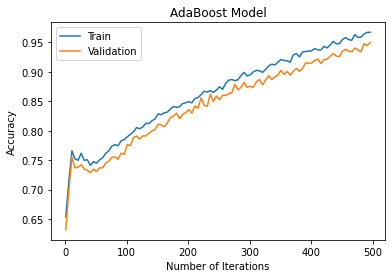

In [8]:
x = iteractions.keys()
train_acc = [acc["train_acc"] for acc in iteractions.values()]
val_acc   = [acc["val_acc"] for acc in iteractions.values()]

# Labels of plot
plt.title("AdaBoost Model")
plt.ylabel("Accuracy")
plt.xlabel("Number of Iterations")

# Plotting train and validation accuracy
plt.plot(x, train_acc, label='Train')
plt.plot(x, val_acc, label='Validation')

plt.legend()
plt.show()